In [1]:
!python --version

Python 3.10.10+


In [1]:
from transformers import BertTokenizer
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
from transformers import BertGenerationEncoder

/home/edgar/.pyenv/versions/introbert/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def tokenize_and_encode(sentence: str, encoder: BertGenerationEncoder, tokenizer: BertTokenizer, max_sentence_len: int = 10) -> torch.Tensor:
    """Tokenizes and encodes sentence, returning a torch tensor"""
    # -- tokenize input
    tokens = tokenizer(sentence, max_length=max_sentence_len, truncation=True).input_ids
    # --  add padding to tokens
    cl = len(tokens)
    ps = max_sentence_len - cl # amount of padding for sentence to be of length max_sentence_len
    tokens_padded = F.pad(torch.tensor(tokens), [-1,ps],"constant",0).unsqueeze(0)
    # -- encode
    outputs = encoder(tokens_padded)
    outputs = outputs.last_hidden_state
    #print(outputs.shape)

    return outputs

def get_top_features(encoded_tensor:torch.Tensor, n_feat: int=3, weight_type: str='rang') -> list[torch.Tensor]:
  """Performs SVD and returns the principal components according to n_feat"""
  u, s, v = torch.svd(encoded_tensor.squeeze(0))
  B_r = u[:, :n_feat] * s[:n_feat] # principal components
  # -- weights
  S = torch.diag(s)
  r = torch.cumsum(S**2 / torch.sum(S**2), 0)
  # the impact that the vector has on the data
  weight = r.mean(0)
    
  match weight_type:
    case 'accum':
        weight = weight / weight.sum()
    case 'rang':
        weight = (weight.max() - weight) / (weight.max() - weight.min())
    case None:
        weight = weight / weight
    case _:
        print("weight type should be 'accum' or 'rang': defaulting to accum")
        weight = weight / weight.sum()
  
  return B_r, weight[:n_feat]

def plot_feat(features:torch.Tensor, sentences:list[str]):
    num_feat = len(features)
    fig, axes = plt.subplots(nrows=1, ncols=num_feat, figsize=(num_feat * 2 , num_feat-1))
    
    for i, ax in enumerate(axes):
        ax.set_title(str(i)+')', y=-0.15)
        ax.imshow(features[i].detach().numpy())
        axes[num_feat-1].text(5, 0.5 * (i+1), str(i) +') '+ sentences[i])
        
    fig.suptitle('Sentence comparison: Tokenized + BertEncoded + SVD',x=.65, fontsize=16)
    fig.show()

def calculate_errors(features:torch.Tensor, weights:torch.Tensor, error_type='mse', non_lin_fn:str ='tanh', threshold=1) -> torch.Tensor:
    from torch import nn
    
    error_measure = nn.MSELoss()
    
    match error_type:
        case 'mse':
            error_measure = nn.MSELoss()
        case 'mae':
            error_measure = nn.L1Loss()
        case 'cre':
            error_measure = nn.CrossEntropyLoss()
        case 'ecl_dst':
            error_measure = ecl_dist
        case _:
            error_measure = nn.MSELoss()
            
    n = len(features)
    
    conf_matrix = torch.zeros(n,n)
    
    for i in range(n):
        for j in range(n):
            error = 0
            #for c in range(len(weights[0])):
            #    error += error_measure(features[i][:,c], features[j][:,c]) * (weights[i] + weights[j] / 2)[c]    
            #conf_matrix[i,j] = error
            conf_matrix[i, j] = error_measure(features[i], features[j])
            
    match non_lin_fn:
        case 'sigmoid':
            sigma = nn.Sigmoid()
        case 'relu':
            sigma = nn.ReLU()
        case 'tanh':
            sigma = nn.Tanh()
        case 'gelu':
            sigma = nn.GELU()
        case 'softmax':
            sigma = nn.Softmax()
        case None:
            sigma = lambda x:  x
        case _ :
            print("Non-existing activation function: Will default to sigmoid")
            sigma = nn.Sigmoid()

    error = sigma(conf_matrix)
    error[error>threshold] = 1000
    
    return error

def plot_error(error:torch.Tensor, sentences:list[str]):    
    plt.imshow(error.detach().numpy(), cmap='jet')
    n = len(sentences)
    plt.title('Cross-comparison: Sentence',x=.5, y=1, fontsize=16)
    #plt.minorticks_on()
    #plt.grid(visible=True, which='major')
    
    for i, s in enumerate(sentences):
        plt.text(1 * n, 0.25 * i, str(i) + ') ' + s)
        
    
def ecl_dist (A: torch.Tensor, B: torch.Tensor) -> torch.Tensor:
    
    dims_A = A.shape
    dims_B = B.shape
    assert dims_A == dims_B, f'dimensions of tenosr A and B must be equal A: {dims_A} != B: {dims_B}'
    
    a = A.flatten()
    b = B.flatten()
    
    return torch.sqrt(sum((a - b)**2))

def kmeans_cluster(data, n_cluster=4):
    from nltk.cluster import KMeansClusterer
    import nltk
    
    data = torch.stack(data).flatten(1).detach().numpy() # [sentence_num, parameters]
    
    kclusterer = KMeansClusterer(n_cluster, distance=nltk.cluster.util.cosine_distance,
                                 repeats=25,avoid_empty_clusters=True)
    
    cluster = kclusterer.cluster(data, assign_clusters=True)
    
    return cluster
    


In [3]:
# -- load pretrained tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# -- load pretrained bert encoder
encoder = BertGenerationEncoder.from_pretrained("bert-base-uncased")
encoder.eval()

# -- load sentences to compare
sentences = ['how is the weather?', 'is it warm outside?', 'a monkey throwing a banana', 'how are you?', 'are you ok?', 'how are you feeling today?']

# -- tokenize and encode inputs
encoded = list(map(lambda sentence: tokenize_and_encode(sentence, encoder, tokenizer), sentences)) # returns list of tokenized and encoded sentence

# -- perform svd
features, weights = list(zip(*map(lambda feature: get_top_features(feature, n_feat=4, weight_type=None), encoded)))

kmeans_cluster(encoded)

You are using a model of type bert to instantiate a model of type bert-generation. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertGenerationEncoder: ['bert.pooler.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'bert.pooler.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'bert.embeddings.token_type_embeddings.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertGenerationEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertGenerationEncoder from the checkpoint of a 

[1, 1, 3, 0, 0, 2]

/tmp/ipykernel_32874/2637063515.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


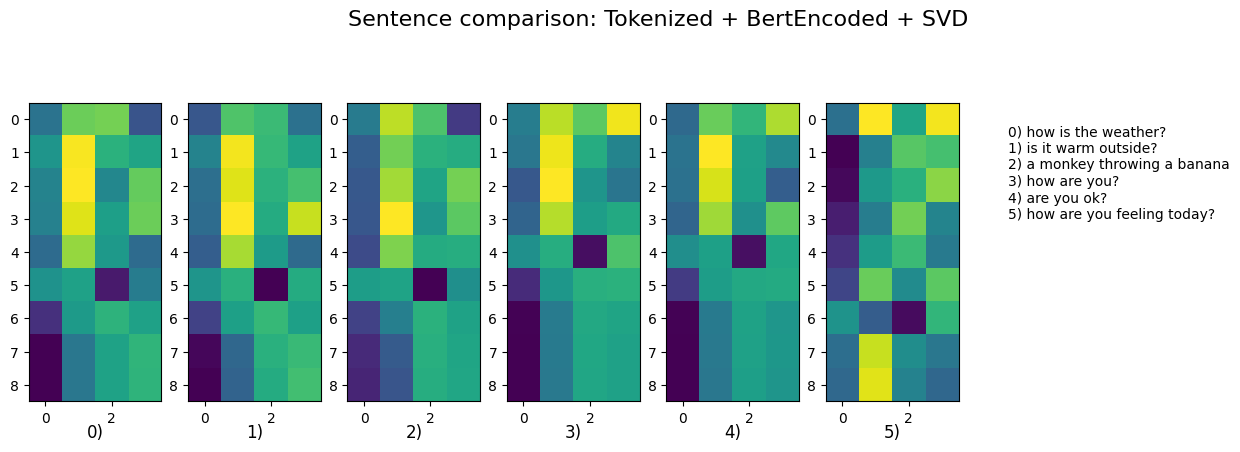

In [4]:
# -- plot features
plot_feat(features, sentences)

In [5]:
# -- k mean 
ecl_dist(torch.tensor(features[3]), torch.tensor(features[4]))

/tmp/ipykernel_32874/1620835914.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ecl_dist(torch.tensor(features[3]), torch.tensor(features[4]))


tensor(8.5010)

tensor([[   0.0000,   11.8416, 1000.0000, 1000.0000, 1000.0000, 1000.0000],
        [  11.8416,    0.0000, 1000.0000, 1000.0000, 1000.0000, 1000.0000],
        [1000.0000, 1000.0000,    0.0000, 1000.0000, 1000.0000, 1000.0000],
        [1000.0000, 1000.0000, 1000.0000,    0.0000,    8.5010, 1000.0000],
        [1000.0000, 1000.0000, 1000.0000,    8.5010,    0.0000, 1000.0000],
        [1000.0000, 1000.0000, 1000.0000, 1000.0000, 1000.0000,    0.0000]],
       grad_fn=<IndexPutBackward0>)


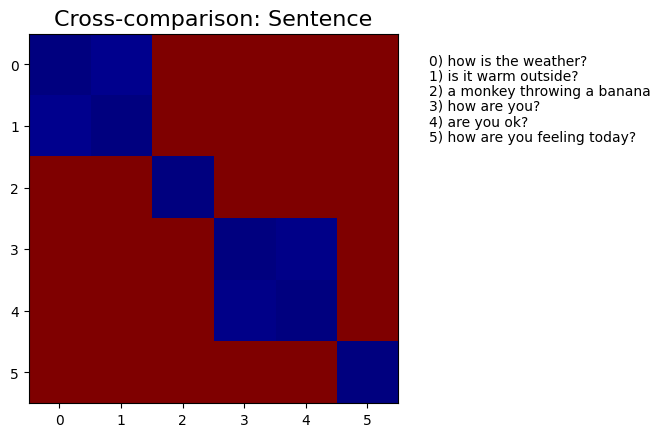

In [6]:
# -- calucalte errors (sentence cross-comparison) 
errors = calculate_errors(features, weights, error_type='ecl_dst', non_lin_fn=None, threshold=15)
print(errors)
plot_error(errors, sentences)

# Manifold

In [7]:
from sklearn.manifold import Isomap

In [8]:
def plot_manifold(A: torch.Tensor, manifold_fn):
    # load isomap
    model = manifold_fn(n_components=2, n_neighbors=5)

    # convert list of tensors to tensors and flatten along dim=1
    ft = torch.stack(features).flatten(1)
    # transform data
    proj = model.fit_transform(ft.detach().numpy())

    # plot data
    plt.figure(dpi=200)
    plt.scatter(proj[:, 0], proj[:, 1])
    plt.title("Isomap clustering")
    
    for i in range(len(proj)):
        plt.annotate(str(i+1), (proj[i, 0], proj[i, 1]))
    #print([i for i in range(proj.shape[0])])
    plt.legend()
    
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


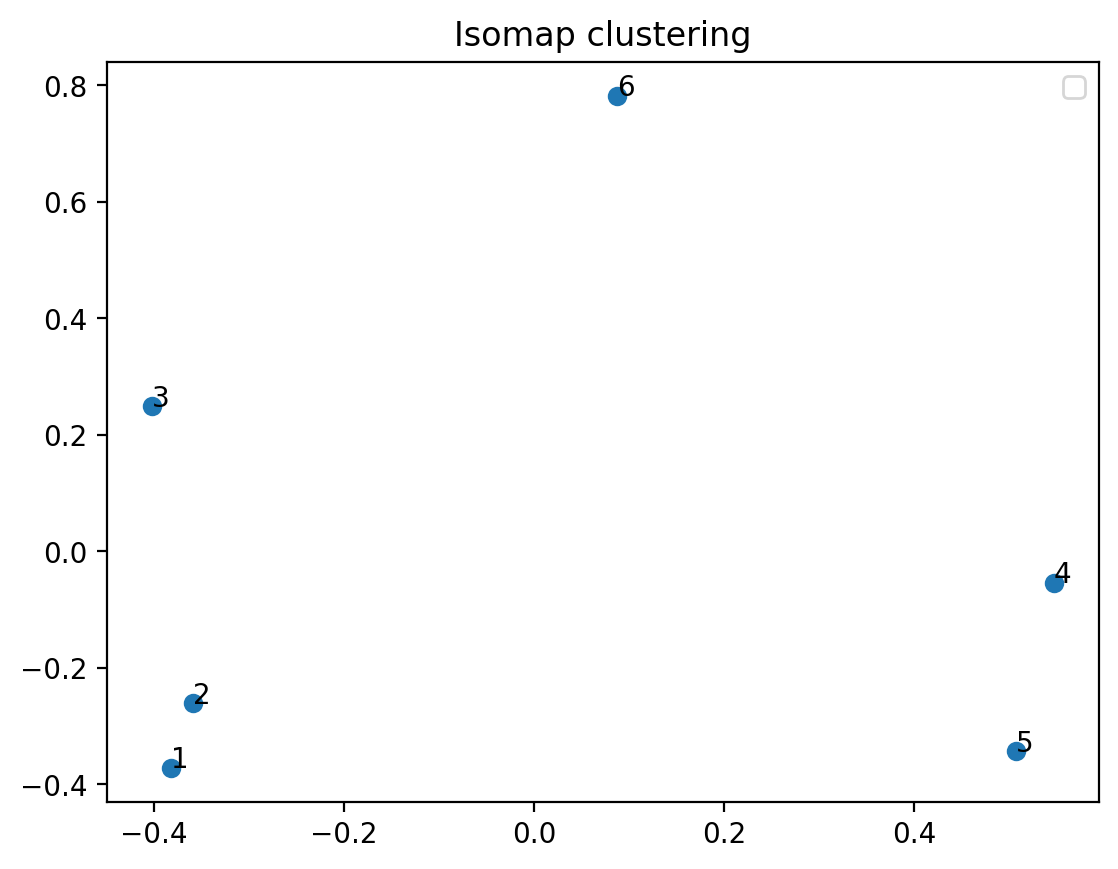

In [9]:
# load manifold model
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
manifold_fn = LocallyLinearEmbedding
plot_manifold(features, manifold_fn)

In [15]:
# full cluster
with(open('dictionary.txt', 'r') as file):
    text = file.read()
    text_as_list = text.split("\n")

# -- tokenize and encode inputs
encoded = list(map(lambda sentence: tokenize_and_encode(sentence, encoder, tokenizer), text_as_list[:-1]))
cluster = kmeans_cluster(encoded, 5)
#print([i for i in range(len(encoded))])
for i, c in enumerate(cluster):
    print(f'{text_as_list[i]}\t{c}')


how are you doing today?	4
how are you?	0
how is it going?	2
how are you feeling?	2
are you happy?	0
are you sad?	0
are you ok?	0
how is the weather?	2
is it hot outside?	3
is it cold outside?	3
is it raining?	0
is it snowing?	2
is it windy?	0
what time is it?	3
Is it three o clock?	3
Is it already 7?	2
Is it noon already?	3
turn off the lamp	1
it is too bright	4
turn on the lamp	1
it is too dark	4
turn off the radio	1
it is too loud	4
turn on the radio	1
it is too quiet	4
have you eaten already?	3
are you hungry?	0
have you drank water today?	4
are you thirsty?	0


In [14]:
# full cluster with pca
with(open('dictionary.txt', 'r') as file):
    text = file.read()
    text_as_list = text.split("\n")

# -- tokenize and encode inputs
encoded = list(map(lambda sentence: tokenize_and_encode(sentence, encoder, tokenizer), text_as_list[:-1]))
features, weights = list(zip(*map(lambda feature: get_top_features(feature, n_feat=4, weight_type=None), encoded)))
cluster = kmeans_cluster(features, 5)
#print([i for i in range(len(encoded))])
for i, c in enumerate(cluster):
    print(f'{text_as_list[i]}\t{c}')


how are you doing today?	3
how are you?	1
how is it going?	2
how are you feeling?	2
are you happy?	1
are you sad?	1
are you ok?	1
how is the weather?	2
is it hot outside?	2
is it cold outside?	2
is it raining?	0
is it snowing?	3
is it windy?	1
what time is it?	2
Is it three o clock?	0
Is it already 7?	2
Is it noon already?	3
turn off the lamp	4
it is too bright	1
turn on the lamp	4
it is too dark	1
turn off the radio	4
it is too loud	1
turn on the radio	4
it is too quiet	1
have you eaten already?	0
are you hungry?	1
have you drank water today?	0
are you thirsty?	1
